# Create a Function that will Assess the Nue/Numu Ratio in Each Universe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


## Load the Samples

## Nue Section

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"
"""
# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND



#actually fetch datasets
nue_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt] 

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)

#To match Krishan's nue selection we need (1) nSlice (SliceID), n_showers_contained
#(2) xyz for reconstructed vertex, contained fraction of hits (3) cosmic impact params
#(4) hit ratio of leading shower to slice (5) moliere angle av, dEdx in first 4cm of shower, shower to vertex dist
#"shower_vtx_dist" not working?
#shr_energy, category, slnunhits, slnhits, slash time, ccnc, nu pdg needed later
nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
nue_mc   = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)
nue_data = nue_data.pandas.df(nue_variables, flatten=False)
nue_ext  = nue_ext.pandas.df(nue_variables, flatten=False)

['tksh_angle', 'trk_energy_tot', 'shr_tkfit_nhits_V', 'trk_score_v', 'shrsubclusters0', 'true_nu_vtx_y', 'shr_score', 'tksh_distance', 'slnhits', 'flash_time', 'topological_score', 'shr_tkfit_nhits_Y', 'n_showers_contained', 'nu_pdg', 'category', 'reco_nu_vtx_sce_y', 'evt', 'true_nu_vtx_z', 'reco_nu_vtx_sce_x', 'selected', 'trkshrhitdist2', 'true_nu_vtx_x', 'shr_distance', 'nproton', 'reco_nu_vtx_sce_z', 'nslice', 'shr_tkfit_dedx_Y', 'slnunhits', 'trk_energy', 'n_showers', 'shr_energy_cali', 'n_tracks_contained', 'hits_ratio', 'run', 'ccnc', 'CosmicIPAll3D', 'n_tracks', 'shrsubclusters2', 'shr_energy_tot_cali', 'contained_fraction', 'nu_e', 'shr_tkfit_npoints', 'shr_tkfit_dedx_V', 'shr_tkfit_nhits_U', 'shr_energy', 'shrmoliereavg', 'sub', 'shr_tkfit_dedx_U', 'shrsubclusters1']


In [3]:
print(len(nue_dirt))
print(nue_dirt.iloc[1:3])
print(len(nue_nue))
print(len(nue_mc))
print(len(nue_data))
print(len(nue_ext))

4634
       shr_score  shr_tkfit_nhits_V  n_tracks_contained  trk_energy_tot  \
entry                                                                     
1       0.386586                  2                   1        0.053697   
2       0.259941                 12                   2        0.425183   

       shr_tkfit_nhits_U  shrmoliereavg  shr_energy_tot_cali  \
entry                                                          
1                      1       6.886888             0.015979   
2                      7      11.288892             0.011676   

       shr_tkfit_npoints  shr_tkfit_dedx_Y      nu_e  ...  true_nu_py  \
entry                                                 ...               
1                     33     -3.402823e+38  2.306945  ...    0.105889   
2                     30      2.745255e+00  1.625897  ...    0.079176   

       true_nu_pz  elec_e  weightSpline  weightTune  weightSplineTimesTune  \
entry                                                             

In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc,nue_nue,nue_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [4]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc,nue_nue,nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [5]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [6]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  15.915930271148682


In [7]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [8]:
df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [9]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])


In [10]:
# add back the cosmic category, for background only
df_v = [nue_mc,nue_nue,nue_ext,nue_data,nue_dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [11]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc,nue_nue,nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        

In [12]:
#Define signal catagories

nue_data["is_signal"] = nue_data["category"] == 11
nue_nue["is_signal"] = nue_nue["category"] == 11
nue_mc["is_signal"] = nue_mc["category"] == 11
nue_dirt["is_signal"] = nue_dirt["category"] == 11
nue_ext["is_signal"] = nue_ext["category"] == 11

nue_nue["is_not_signal"] = nue_nue["category"] != 11

In [13]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')
nue_nue  = nue_nue.query('nu_e > 0.')
nue_dirt = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc,nue_nue,nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [14]:
df_v = [nue_mc,nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## NuMu

In [15]:
tree = "NeutrinoSelectionFilter"

"""
#new
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
#This is with the new GENIE tune
#NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND
"""
BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
numu_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
numu_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
#nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]


uproot_v = [numu_mc,numu_ext,numu_data,numu_dirt] 


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        #"trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
        #"trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
        #"trk_start_x_v","trk_start_z_v","trk_start_z_v",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
        "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x", "nu_e"
    ]

numu_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['npion', 'slclustfrac', 'true_e_visible', 'trk_llr_pid_score_v', 'pi0truth_elec_etot', 'reco_nu_vtx_y', 'true_nu_vtx_y', 'flash_pe', '_opfilter_pe_beam', 'isVtxInFiducial', 'slpdg', 'slnhits', '_opfilter_pe_veto', 'theta', 'topological_score', 'nu_pdg', 'category', 'interaction', 'reco_nu_vtx_sce_y', 'evt', 'true_nu_vtx_z', 'reco_nu_vtx_sce_x', 'CosmicIP', 'pion_e', 'CosmicDirAll3D', 'true_nu_vtx_x', 'nproton', 'backtracked_pdg', 'reco_nu_vtx_sce_z', 'nslice', 'slnunhits', 'reco_nu_vtx_x', 'reco_e', 'ccnc', 'run', 'npi0', 'CosmicIPAll3D', 'evnunhits', 'nu_e', 'mc_pdg', 'reco_nu_vtx_z', 'pi0_e', 'muon_e', 'sub']


In [16]:
import pandas as pandas    
#dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)
#mc   =   mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
#data = data.pandas.df(variables, flatten=False)
#ext  =  ext.pandas.df(variables, flatten=False)

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS
mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+numu_varMC
data_var = numu_variables
ext_var  = numu_variables
#nue_var  = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC


# This needs modifications (add variables from above)
uproot_v = [numu_mc,numu_ext,numu_data,numu_dirt] 
var_v    = [mc_var,ext_var,data_var,dirt_var] 

#nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF
        print("1")
    elif ii == 1:
        numu_ext = CVDF
        print("2")
    elif ii == 2:
        numu_data = CVDF
        print("3")
    else:
        numu_dirt =  CVDF
        print("4")


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


1
2
3
4


In [17]:
df_v = [numu_mc,numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [18]:
df_v = [numu_mc,numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']

In [19]:
df_v = [numu_mc,numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [20]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [21]:
df_v = [numu_mc,numu_dirt,numu_data,numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [22]:
df_v = [numu_mc,numu_dirt,numu_data,numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])
numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [23]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)


/tmp/ipykernel_4795/3728966960.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


In [24]:
numu_data["is_signal"] = numu_data["category"] == 11
numu_mc["is_signal"]   = numu_mc["category"] == 11
numu_dirt["is_signal"] = numu_dirt["category"] == 11
numu_ext["is_signal"]  = numu_ext["category"] == 11

In [25]:
numu_mc   = numu_mc.query('nu_e > 0.')
#numu_nue  = numu_nue.query('nu_e > 0.')
numu_dirt = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc,numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

## Nue Selection

In [26]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [27]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [28]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc, nue_nue, nue_dirt, nue_ext, nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(46815, 113)
(67348, 114)
(4634, 95)
(6087, 68)
(7502, 68)


In [29]:
datasets_bdt = nue_mc

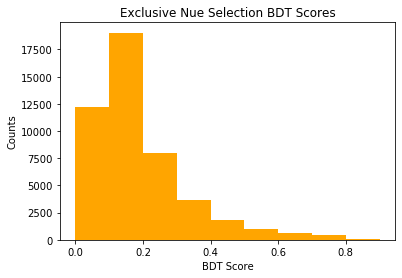

In [30]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [31]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

## Numu Selection

In [32]:
NUMU_SEL_QUERY = 'nslice == 1'
NUMU_SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
NUMU_SEL_QUERY += ' and n_muons_tot > 0'
NUMU_SEL_QUERY += ' and n_protons_tot > 0 '

## Truth Selections

In [33]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

## Plotter

In [36]:
import plotter_alex
import importlib
importlib.reload(plotter_alex)
scaling = 1

SPLIT = 1.0

numu_nue   = numu_mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")

samples = {
    "nue_mc": nue_mc,
    "nue_nue": nue_nue,
    "nue_data": nue_data,
    "nue_dirt": nue_dirt,
    "nue_ext": nue_ext,
    "numu_mc": numu_mc,
    "numu_nue": numu_nue,
    "numu_data": numu_data,
    "numu_dirt": numu_dirt,
    "numu_ext": numu_ext    
}


scaling = 1
# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 #partial file: 8.885e+19
mcratio   = pot/2.33652e+21 
nueratio  = pot/2.37838e+22 
dirtratio = pot/1.42143e+21
extratio  = 5268051/9199232.74
SPLIT = 1.0
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98
 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
scalingDRTnue = 0.35
scalingDRTnumu = 0.60


# NUE
weights = { #full sample mc = 0.38
            "nue_mc"  : mcratio  * SPLIT * scaling,   
            "nue_nue" : nueratio * SPLIT * scaling,  
            "nue_ext" : extratio * SPLIT * scalingEXT, #set0   
            "nue_dirt": dirtratio* SPLIT * scalingDRTnue, #set0 
            "numu_mc"  : mcratio  * SPLIT * scaling,
            "numu_nue"  : mcratio  * SPLIT * scaling,
            "numu_ext" : extratio * SPLIT * scalingEXT,    
            "numu_dirt": dirtratio* SPLIT * scalingDRTnumu, 
}




print (nue_ext.shape)
my_plotter = plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

#BDT

(6087, 68)
{'nue_mc': 0.08559738414394057, 'nue_nue': 0.008409085175623745, 'nue_ext': 0.5612087579382191, 'nue_dirt': 0.049246181662128984, 'numu_mc': 0.08559738414394057, 'numu_nue': 0.08559738414394057, 'numu_ext': 0.5612087579382191, 'numu_dirt': 0.08442202570650682}


(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
nue_category_mc_unis []
nue_category []
nue total  382.3425653293798
[0.0, 0.0, 0.0, 0.33261140818791546, 0.0, 0.401709130044992]

SUMS
[0.05927902685497141, 0.14546793714651995, 1.0094312044518976, 6.663576724895168, 111.75253259131607, 111.75253259131607, 382.34256532938025]
[0.08618891029154854, 0.8639632673053776, 5.6541455204432705, 105.0889558664209, 0.0, 270.59003273806417]

Wan

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


[0.0, 0.0, 0.7898935014453059, 3.154809746774845e-10]

SUMS
[5.711967039534396, 12.284600700992844, 43.20523353072654, 423.5897846629433, 1059.1021114803043]
[6.572633661458448, 30.920632829733695, 380.38455113221676, 635.512326817361]

Wanted List:
[216.90345210456155, 242.07310480713969, 120.84132770198254, 42.191528660680426, 9.596673958917677, 2.4346610874607677, 0.9293863649895684, 0.45534912407208594, 0.0, 0.08684300724098648]

True
Full numbers =  [1419. 3404. 3028. 2429. 1207.  524.  324.  188.  104.   88.]
Selected numbers =  [1419. 3403. 3028. 2429. 1207.  524.  324.  187.  104.   88.]
In bin 0 , eff =  1.0  with error =  0.0
In bin 1 , eff =  0.9997062279670975  with error =  0.0002937288787292129
In bin 2 , eff =  1.0  with error =  0.0
In bin 3 , eff =  1.0  with error =  0.0
In bin 4 , eff =  1.0  with error =  0.0
In bin 5 , eff =  1.0  with error =  0.0
In bin 6 , eff =  1.0  with error =  0.0
In bin 7 , eff =  0.9946808510638298  with error =  0.005304983401203847
In b


cov sys err: =  [[2.169e+00 4.525e+00 2.139e+00 1.002e+00 3.194e-01 2.216e-01 1.361e-01
  1.066e-01 1.353e-02 3.958e-03]
 [4.525e+00 9.625e+00 4.648e+00 2.171e+00 7.001e-01 4.904e-01 2.908e-01
  2.251e-01 3.393e-02 1.129e-02]
 [2.139e+00 4.648e+00 2.296e+00 1.069e+00 3.479e-01 2.468e-01 1.413e-01
  1.080e-01 1.916e-02 6.973e-03]
 [1.002e+00 2.171e+00 1.069e+00 4.985e-01 1.621e-01 1.147e-01 6.596e-02
  5.046e-02 8.781e-03 3.170e-03]
 [3.194e-01 7.001e-01 3.479e-01 1.621e-01 5.381e-02 3.759e-02 2.116e-02
  1.613e-02 2.944e-03 1.104e-03]
 [2.216e-01 4.904e-01 2.468e-01 1.147e-01 3.759e-02 2.694e-02 1.497e-02
  1.132e-02 2.266e-03 8.703e-04]
 [1.361e-01 2.908e-01 1.413e-01 6.596e-02 2.116e-02 1.497e-02 8.841e-03
  6.807e-03 1.081e-03 3.683e-04]
 [1.066e-01 2.251e-01 1.080e-01 5.046e-02 1.613e-02 1.132e-02 6.807e-03
  5.288e-03 7.591e-04 2.429e-04]
 [1.353e-02 3.393e-02 1.916e-02 8.781e-03 2.944e-03 2.266e-03 1.081e-03
  7.591e-04 2.717e-04 1.221e-04]
 [3.958e-03 1.129e-02 6.973e-03 3.170e


cov sys err: =  [[52.867 89.361 63.159 20.158 8.076 3.344 0.969 2.263 -0.366 0.097]
 [89.361 151.078 106.847 34.109 13.701 5.656 1.647 3.838 -0.618 0.164]
 [63.159 106.847 75.815 24.259 9.857 4.020 1.186 2.759 -0.431 0.112]
 [20.158 34.109 24.259 7.809 3.203 1.297 0.383 0.894 -0.136 0.035]
 [8.076 13.701 9.857 3.203 1.375 0.531 0.167 0.380 -0.052 0.012]
 [3.344 5.656 4.020 1.297 0.531 0.216 0.063 0.148 -0.023 0.006]
 [0.969 1.647 1.186 0.383 0.167 0.063 0.021 0.046 -0.006 0.001]
 [2.263 3.838 2.759 0.894 0.380 0.148 0.046 0.106 -0.015 0.003]
 [-0.366 -0.618 -0.431 -0.136 -0.052 -0.023 -0.006 -0.015 0.003 -0.001]
 [0.097 0.164 0.112 0.035 0.012 0.006 0.001 0.003 -0.001 0.000]]

Add Drawing Geo Sys (numu)
Number of variations Universes 10

variation number  0
n_tot
[[283.222 384.839 241.600 101.518 31.607 10.808 4.325 2.611 0.817 0.129]
 [283.233 386.299 242.655 101.763 31.662 10.897 4.428 2.670 0.826 0.128]]
--------##--------
n_cv_tot
[282.935 384.685 241.264 100.684 31.155 10.670 4.2


bin_cv_ratios in geo sys:
[0.28272095, 0.42788327, 0.3283276, 0.31194404, 0.46900272, 0.62645864, 0.73825186, 0.6755066, 0.92964506, 1.9024913]


2
[[0.283 0.425 0.323 0.308 0.456 0.601 0.665 0.601 0.825 1.713]
 [0.280 0.421 0.323 0.309 0.469 0.622 0.701 0.621 0.857 1.748]]

n_tot
[[0.283 0.425 0.323 0.308 0.456 0.601 0.665 0.601 0.825 1.713]
 [0.280 0.421 0.323 0.309 0.469 0.622 0.701 0.621 0.857 1.748]]
--------##--------
n_cv_tot
[0.283 0.428 0.328 0.312 0.469 0.626 0.738 0.676 0.930 1.902]
------------------

bin_cv_ratios in geo sys:
[0.28272095, 0.42788327, 0.3283276, 0.31194404, 0.46900272, 0.62645864, 0.73825186, 0.6755066, 0.92964506, 1.9024913]


2
[[0.281 0.424 0.322 0.305 0.455 0.604 0.687 0.616 0.843 1.700]
 [0.282 0.424 0.323 0.306 0.457 0.595 0.679 0.617 0.848 1.776]]

n_tot
[[0.281 0.424 0.322 0.305 0.455 0.604 0.687 0.616 0.843 1.700]
 [0.282 0.424 0.323 0.306 0.457 0.595 0.679 0.617 0.848 1.776]]
--------##--------
n_cv_tot
[0.283 0.428 0.328 0.312 0.469 0.626 0.738 

/home/alex/NuMI/PELEE/plotter_alex.py:467: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/alex/NuMI/PELEE/plotter_alex.py:273: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


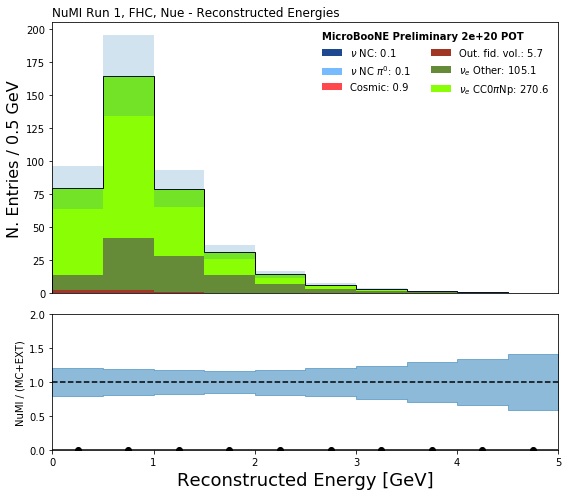

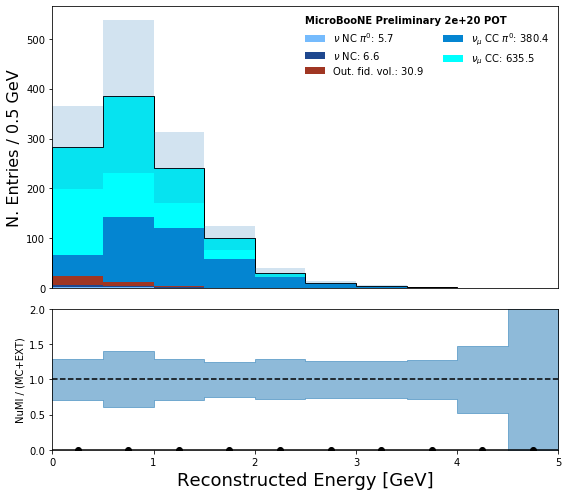

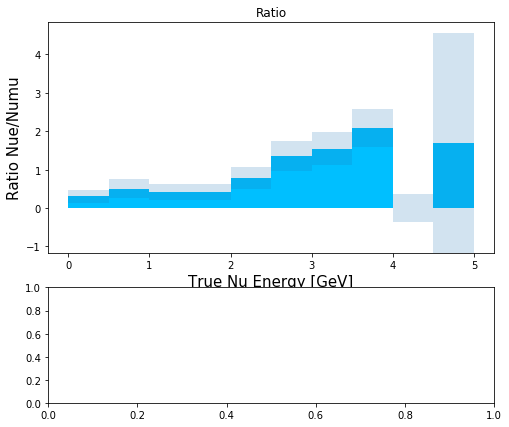

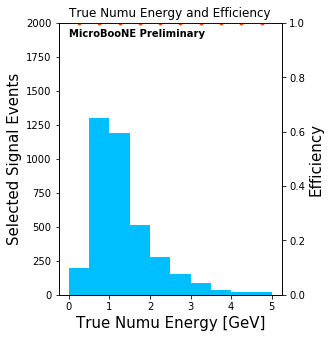

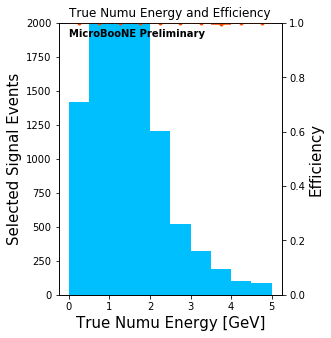

In [37]:
#Now check on a variable

#Remember to change the plotter keys between truth and mc

VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    #nue_query= NUE_SEL_QUERY,
    #numu_query= NUMU_SEL_QUERY,
    nue_query= truthsel_nue,
    numu_query= truthsel_numu,
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()